## Process Data


### Import Nescessary Library

In [175]:
import data_utils as dt #Read Json file and create diction of text and markup
import Error_Checking as ck # All functions to detect similar errors
import string
import math
import nltk
from difflib import SequenceMatcher 
import matplotlib.pyplot as plt
from nltk.book import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


### Read the data

In [176]:
# Data is a list of dictionaries of text and its markup
data = dt.process_data('Data/tai-documents-v3/tai-documents-v3.json')

In [177]:
len(data)

210

In [178]:
type(data)

list

In [179]:
type(data[0])

dict

In [180]:
data[0].keys()

dict_keys(['plaintext', 'markup'])

### A example of markup

In [181]:
data[0]['markup']

[{'comment': '',
  'end_index': 11,
  'new_text': 'there.',
  'old_text': 'there',
  'start_index': 6,
  'type': 'punctuation'},
 {'comment': '',
  'end_index': 59,
  'new_text': None,
  'old_text': '.',
  'start_index': 58,
  'type': 'punctuation'},
 {'comment': '',
  'end_index': 85,
  'new_text': 'G',
  'old_text': 'g',
  'start_index': 84,
  'type': 'grammar'},
 {'comment': '',
  'end_index': 90,
  'new_text': 'R',
  'old_text': 'r',
  'start_index': 89,
  'type': 'grammar'},
 {'comment': '',
  'end_index': 397,
  'new_text': 'stripped wheat and yelped',
  'old_text': 'stripped wheat and yelped',
  'start_index': 372,
  'type': 'word choice'},
 {'comment': '',
  'end_index': 575,
  'new_text': None,
  'old_text': 'it is your favorite own',
  'start_index': 552,
  'type': 'word choice'},
 {'comment': '',
  'end_index': 611,
  'new_text': 'Gold Rush',
  'old_text': 'gold rush',
  'start_index': 602,
  'type': 'grammar'},
 {'comment': '',
  'end_index': 93,
  'new_text': 'Gold Rush',


In [182]:
type(data[0])

dict

#### The number of errors for each type: word choice, grammar, punctuation, and spelling

In [183]:
type_er_dist = nltk.FreqDist([error['type'] for essay in data for error in essay['markup']])
type_er_dist

FreqDist({'grammar': 801,
          'punctuation': 1449,
          'spelling': 974,
          'word choice': 542})

In [184]:
punc_total, sp_total, gm_total, wc_total = (type_er_dist['punctuation'], 
    type_er_dist['spelling'], type_er_dist['grammar'] ,type_er_dist['word choice'])

In [185]:
# Total Number of error
total_error_cnt = punc_total + sp_total + gm_total + wc_total
total_error_cnt

3766

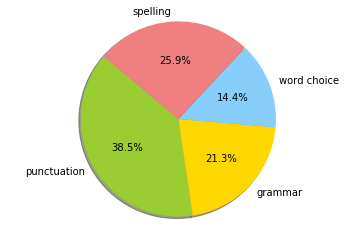

In [186]:
# Plot the distribution of 4 types of error
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(type_er_dist.values(), labels=type_er_dist.keys(), colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

## Process each essay and find similar error

### Word Choice

#### Testing our similar word choice detecting on sample test 

In [187]:
# Sample test
word_choice_test = {'plaintext' : 'aaaaa', 'markup' : [{'start_index': 6,
                      'end_index': 11,
                      'old_text': 'dad',
                      'new_text': 'father',
                      'type': 'word choice',
                      'comment': ''}, 
                      {'start_index': 10,
                      'end_index': 11,
                      'old_text': 'dady',
                      'new_text': 'father',
                      'type': 'word choice',
                      'comment': ''},
                      {'start_index': 20,
                      'end_index': 25,
                      'old_text': 'mom',
                      'new_text': 'mother',
                      'type': 'word choice',
                      'comment': ''}]}

In [188]:
ck.word_choice(word_choice_test)

[{'error_count': 2, 'index': [0, 1], 'words': {'dad', 'dady', 'father'}},
 {'error_count': 1, 'index': [2], 'words': {'mom', 'mother'}}]

#### Running word_choice checking similar error on grade 4 essay dataset to check if student offen repeat word_choice error in an essay


In [189]:
wc_freq = [wc_error['error_count'] for essay in data for wc_error in ck.word_choice(essay)]
wc_freq_dict = nltk.FreqDist(wc_freq)

In [190]:
wc_freq_dict.most_common(5)

[(1, 400), (2, 43), (3, 6), (6, 2), (4, 2)]

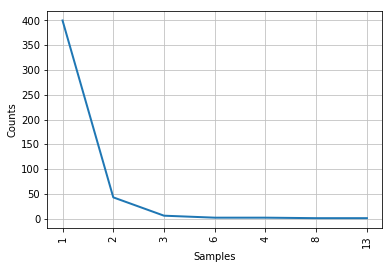

In [191]:
wc_freq_dict.plot()

In [192]:
# Total number repeated error
wc_repeated_cnt = sum([1 for cnt in wc_freq if cnt > 1])

# Total number of different word_choice error
wc_total = sum(wc_freq)

# In total all the word_choice error, the pecent of error appear more than 1 in an essay
(wc_repeated_cnt * 100.0) / wc_total

10.091743119266056

#### Find the most common word choice errors that all student made

In [193]:
# Tuple of set of word of word choice error and its appearance
word_set_freq = [[wc_error['words'], wc_error['error_count']] for essay in data for wc_error in ck.word_choice(essay)]
word_set_freq_merge = []
rm_index_set = set()
for i in range(len(word_set_freq)):
    if i not in rm_index_set:
        c = word_set_freq[i]
        for j in range(i+1, len(word_set_freq)):
            if j not in rm_index_set:
                tmp = word_set_freq[j]
                for w in tmp[0]:
                    if w in c[0]:
                        c[1] = c[1] + tmp[1]
                        rm_index_set.add(j)
                        break        
        word_set_freq_merge.append(c)
        
word_set_freq_dict =  nltk.FreqDist([', '.join(err[0]) for err in word_set_freq_merge for i in range(err[1])])     
word_set_freq_dict.most_common(10)       

[(', it', 51),
 ('also, and', 34),
 ('are, is', 17),
 (' ,  For example,', 13),
 ('there, their', 13),
 ('do, to', 9),
 ('of, or', 8),
 ('the', 8),
 ('., stone.', 6),
 ('then', 6)]

### Punctuation Error

#### Test run on a custom input and on data

In [194]:
# Custom input
punctuation_test = {'plaintext' : 'aaaaa', 'markup' : [
                    {'start_index': 1824,
                  'end_index': 1825,
                  'old_text': '',
                  'new_text': '.',
                  'type': 'punctuation',
                  'comment': ''}, 
                    {'start_index': 138,
                   'end_index': 139,
                   'old_text': '.',
                   'new_text': '?',
                   'type': 'punctuation',
                   'comment': ''},
                      {'start_index': 235,
                  'end_index': 236,
                  'old_text': '',
                  'new_text': ',',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 400,
                  'end_index': 401,
                  'old_text': 't',
                  'new_text': 'T',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 592,
                  'end_index': 594,
                  'old_text': 'f',
                  'new_text': '.  F',
                  'type': 'punctuation',
                  'comment': ''},
                 {'start_index': 620,
                  'end_index': 621,
                  'old_text': 'w',
                  'new_text': 'W',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 67,
                  'end_index': 78,
                  'old_text': 'is surprise',
                  'new_text': 'is, surprise',
                  'type': 'punctuation',
                  'comment': ''},
                 {'start_index': 398,
                  'end_index': 406,
                  'old_text': 'is three',
                  'new_text': 'is, three',
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 407,
                  'end_index': 421,
                  'old_text': "strikes you're",
                  'new_text': "strikes, you're",
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 977,
                  'end_index': 978,
                  'old_text': 'I',
                  'new_text': None,
                  'type': 'punctuation',
                  'comment': ''},
                    {'start_index': 977,
                  'end_index': 978,
                  'old_text': 'w',
                  'new_text': 'Well',
                  'type': 'punctuation',
                  'comment': ''},
            ]}

In [195]:
ck.punctuation_error(data[9])

{'capitalization_error': {'definition': 'Errors on capitalization',
  'error_count': 1,
  'index': [4]},
 'error_use .': {'definition': 'Wrong used or missing using of .',
  'error_count': 1,
  'index': [2]},
 'misleading .?': {'definition': 'Errors of misleading between . and ?',
  'error_count': 1,
  'index': [0]},
 'other_error': {'definition': 'other errors',
  'error_count': 5,
  'index': [1, 3, 5, 7, 9]}}

In [196]:
# On an essay in dataset
data[9]['markup']

[{'comment': '',
  'end_index': 139,
  'new_text': '?',
  'old_text': '.',
  'start_index': 138,
  'type': 'punctuation'},
 {'comment': '',
  'end_index': 148,
  'new_text': 'Well',
  'old_text': 'w',
  'start_index': 147,
  'type': 'punctuation'},
 {'comment': 'add period',
  'end_index': 232,
  'new_text': ' .',
  'old_text': ' ',
  'start_index': 231,
  'type': 'punctuation'},
 {'comment': '',
  'end_index': 233,
  'new_text': None,
  'old_text': 't',
  'start_index': 232,
  'type': 'punctuation'},
 {'comment': '',
  'end_index': 338,
  'new_text': 'i',
  'old_text': 'i',
  'start_index': 337,
  'type': 'punctuation'},
 {'comment': '',
  'end_index': 607,
  'new_text': None,
  'old_text': 'also',
  'start_index': 603,
  'type': 'punctuation'},
 {'comment': '',
  'end_index': 704,
  'new_text': 'well',
  'old_text': 'good',
  'start_index': 700,
  'type': 'word choice'},
 {'comment': '',
  'end_index': 755,
  'new_text': None,
  'old_text': 'my',
  'start_index': 753,
  'type': 'punc

In [197]:
ck.punctuation_error(punctuation_test)


{'capitalization_error': {'definition': 'Errors on capitalization',
  'error_count': 2,
  'index': [3, 5]},
 'error_use ,': {'definition': 'Wrong used or missing using of ,',
  'error_count': 4,
  'index': [2, 6, 7, 8]},
 'error_use .': {'definition': 'Wrong used or missing using of .',
  'error_count': 2,
  'index': [0, 4]},
 'misleading .?': {'definition': 'Errors of misleading between . and ?',
  'error_count': 1,
  'index': [1]},
 'other_error': {'definition': 'other errors',
  'error_count': 2,
  'index': [9, 10]}}

#### Make sure that total error we count equal total of punctuation error in input

In [198]:
assert(len([k for k in punctuation_test['markup'] if k['type'] == 'punctuation']) == 
       sum(error['error_count'] for error in ck.punctuation_error(punctuation_test).values()))

In [199]:
for essay in data:
    assert(len([p for p in essay['markup'] if p['type'] == 'punctuation']) == 
           sum(error['error_count'] for error in ck.punctuation_error(essay).values()))

#### Some Stat for counting punctuation error

##### Total Number of punctuation errors were marked

In [200]:
punc_total

1449

##### Total Number of punctuation errors that we can classify (Not put on other_error)

In [201]:
ctb_punc_error = sum([error[1]['error_count'] for essay in data 
                      for error in ck.punctuation_error(essay).items() 
                      if error[0] != 'other_error'])
ctb_punc_error

1034

##### Percent of punctuation error that we can classify

In [202]:
Punc_classify_rate = (ctb_punc_error * 100.0) / punc_total
Punc_classify_rate

71.35955831608005

##### Distribution of the repeatable of a type of error in an essay
We want to check how frequently a student make the same punctuation error in an essay

In [203]:
# A list of number of each type of punctuation error in an essay for the whole dataset
repeat_error_cnt = [error[1]['error_count'] for essay in data 
                      for error in ck.punctuation_error(essay).items() 
                      if error[0] != 'other_error']

In [204]:
error_cnt_freq = nltk.FreqDist(repeat_error_cnt)
error_cnt_freq.most_common(5)

[(1, 134), (2, 66), (3, 40), (4, 17), (7, 14)]

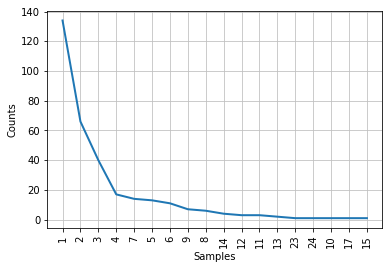

In [205]:
error_cnt_freq.plot()

In [206]:
# Number of repeated error
punc_repeated_cnt = sum([num for num in repeat_error_cnt if num > 1])

# Percent of repeated punctuation error 
punc_repeated_cnt * 100.0/punc_total

62.11180124223603

##### Now we want to find for all student in grade 4, which punctuation errors that they usually make

In [207]:
# List of All punc_error in all essays after classify
punc_errors = [error for essay in data 
                      for error in ck.punctuation_error(essay).items() 
                      if error[0] != 'other_error']

# All different error types
punc_error_type = set([p_type[0] for p_type in punc_errors])
punc_error_type



{'capitalization_error',
 'error_use !',
 'error_use "',
 "error_use '",
 'error_use ,',
 'error_use -',
 'error_use .',
 'error_use :',
 'error_use ?',
 'misleading !?',
 'misleading ,.',
 'misleading ,?',
 'misleading -.',
 'misleading .!',
 'misleading .,',
 'misleading .?',
 "misleading :'",
 'misleading ?,',
 'misleading ?.'}

In [208]:
# Each type with total number of appearance
error_cnt_total = {key : sum([error[1]['error_count'] 
                              for error in punc_errors if error[0] == key]) 
                   for key in punc_error_type} 

error_cnt_total

{'capitalization_error': 110,
 'error_use !': 2,
 'error_use "': 1,
 "error_use '": 22,
 'error_use ,': 544,
 'error_use -': 7,
 'error_use .': 229,
 'error_use :': 4,
 'error_use ?': 35,
 'misleading !?': 5,
 'misleading ,.': 23,
 'misleading ,?': 4,
 'misleading -.': 1,
 'misleading .!': 3,
 'misleading .,': 18,
 'misleading .?': 20,
 "misleading :'": 1,
 'misleading ?,': 1,
 'misleading ?.': 4}

In [209]:
# There still dublicated in the ressult like 'misleading ,?' and 'misleading ?,'
# We're going to merge them
error_cnt_total_fix = error_cnt_total.copy()
for k in error_cnt_total:
    if(k[:10] == 'misleading' and k in error_cnt_total_fix):
        deleted_key = 'misleading ' + k[12] + k[11]
        if deleted_key in error_cnt_total_fix:
            error_cnt_total_fix[k] = error_cnt_total_fix[k] + error_cnt_total_fix[deleted_key]
            del error_cnt_total_fix[deleted_key]
error_cnt_total_fix

{'capitalization_error': 110,
 'error_use !': 2,
 'error_use "': 1,
 "error_use '": 22,
 'error_use ,': 544,
 'error_use -': 7,
 'error_use .': 229,
 'error_use :': 4,
 'error_use ?': 35,
 'misleading !?': 5,
 'misleading -.': 1,
 'misleading .!': 3,
 'misleading .,': 41,
 "misleading :'": 1,
 'misleading ?,': 5,
 'misleading ?.': 24}

In [210]:
# Most five common types 
punc_error_cnt_total_dict = nltk.FreqDist(error_cnt_total_fix)
punc_error_cnt_total_dict.most_common(5)

[('error_use ,', 544),
 ('error_use .', 229),
 ('capitalization_error', 110),
 ('misleading .,', 41),
 ('error_use ?', 35)]

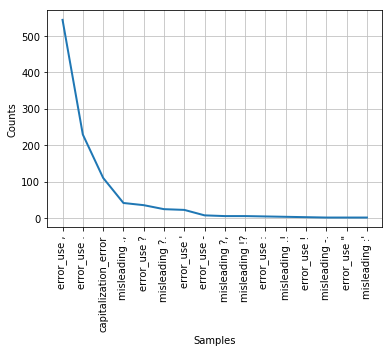

In [211]:
# Graph
punc_error_cnt_total_dict.plot()

## Spelling

In [212]:
#Function to return common substring
def sub(str1,str2): 
    seqMatch = SequenceMatcher(None,str1,str2) 
    match = seqMatch.find_longest_match(0, len(str1), 0, len(str2)) 
    if (match.size!=0):
        z=str1[match.a: match.a + match.size]
        return z
#Function that compares two words and deletes the common words at the same index this gives the error pattern
def de(str1,str2,str3):
    a=dict()
    c=None
    for i in str1:
        for j in str2:
            if(i==j and str1.index(i)==str2.index(j)):
                c=str1.replace(i,'')
            
    z=[]           
    if c==None:
        return
    if c not in a.keys():
        a[c]=[str1,str3]
        z=z+[(str1,str3)]
    else:
        a[c]=a[c]+[str1,str3]
        z=z+[(str1,str3)]
    return a
	
#Function that iterates over the documents to get the pattern and their errors
def spel(i):
    a=[error['old_text'] for error in data[i]['markup'] if error['type'] == 'spelling']
    b=[error['new_text'] for error in data[i]['markup'] if error['type'] == 'spelling']
    co=0
    e=dict()
    for i in range(0,len(a)-1):
        for j in range(i,len(a)-1):
            if i!=j:
                c=sub(a[i],a[j])
                if(c!=None and len(c)>3 and b[j]!=None):
                    d=de(a[j],b[j],a[i])
                    if(d is not None):
                        for k in d.keys():
                            e[k]=d[k]
    if e!=None:
        r1=0
        g=dict()
        for i in e.keys():
            if len(e[i])>1:
                g[i]=len(e[i])
                r1=r1+len(e[i])
        #UNCOMMENT THIS CODE TO FIND THE COMMON SPELLING MISTAKES FOR EACH DOCUMENT
        #print("common error patterns",end=' ')
        #print([i for i in e.keys() if len(e[i])>1])
        #print("common error words", end=' ')
        #print([v for v in e.values() if len(e[i])>1] )


        #print("percentage of common errors:",end=' ')
        #if(len(a)!=0):
         #   print((r1*100)/len(a))
        #else:
         #   print("No spelling errors found")

        #plt.bar(g.keys(), g.values(), 1, color='g')
        #plt.show()
        return e
#Function to find the common spelling error in the whole data set
def act():
    f=dict()
    m,k=0,0
    for i in range(0,209):
        e=spel(i)
        if e is not None:
            for i in e.keys():
                if i not in f.keys():
                    f[i]=e[i]
                    k=k+len(e[i])
                else:
                    f[i]=f[i]+e[i]
                    k=k+len(e[i])
                    
    c=[(len(f[i]),i) for i in f.keys() if len(f[i])>2]
    print("The common spelling errors among the whole data set is")
    h=dict()
    for i in c:
        h[i[1]]=len(f[i[1]])
        print(i[1],f[i[1]])
    plt.bar(h.keys(),h.values(),1, color='b')
    plt.show()
    return k

    


The common spelling errors among the whole data set is
sta ['star', 'star', 'staff', 'staff']
yor ['your', 'your', 'your', 'your']
the ['they', 'they', 'they', 'they']


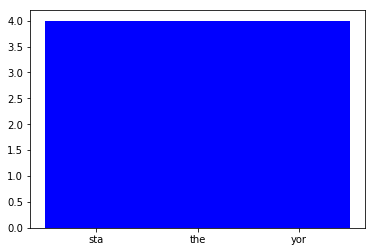

Percentage of Spelling errors similar
15.637860082304528


In [213]:
a=0
g=act()
for i in range(0,209):
    a=a+len([error['old_text'] for error in data[i]['markup'] if error['type'] == 'spelling'])
print("Percentage of Spelling errors similar")
if g!=0:
    print(g*100/a)
else:
    print("No spelling errors found")

# Summary

### Percent of error can be classified

In [214]:
# Total Error can classify
total_err_classify = ctb_punc_error + wc_total + sp_total
total_err_classify

2553

In [215]:
# Percent of errors can classify
total_err_classify * 100.0 / total_error_cnt

67.79075942644715

### Percent of error is duplicated in an essay

In [216]:
# Number of dublicated error (appearing more than 2 in an essay)
dub_cnt = punc_repeated_cnt + wc_repeated_cnt + g
dub_cnt

1107

In [217]:
# percentage
dub_cnt / total_err_classify

0.4336075205640423

### Which is the most common error for all students in those three type

In [224]:
z=FreqDist(z)
# Gather all the FreqDist of those 3 type
total_error_freq_dist = word_set_freq_dict + punc_error_cnt_total_dict + z

In [223]:
# Most common error of all three type
total_error_freq_dist.most_common(20)

[('error_use ,', 544),
 ('error_use .', 229),
 ('capitalization_error', 110),
 (', it', 51),
 ('misleading .,', 41),
 ('error_use ?', 35),
 ('also, and', 34),
 ('misleading ?.', 24),
 ("error_use '", 22),
 ('are, is', 17),
 (' ,  For example,', 13),
 ('there, their', 13),
 ('do, to', 9),
 ('of, or', 8),
 ('the', 8),
 ('error_use -', 7),
 ('., stone.', 6),
 ('then', 6),
 ('in', 6),
 ("your, you're", 6)]